# Multi-Class Classification with XGBoost

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample = pd.read_csv('sampleSubmission.csv')

In [3]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
test_df.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Id          884262 non-null  int64  
 1   Dates       884262 non-null  object 
 2   DayOfWeek   884262 non-null  object 
 3   PdDistrict  884262 non-null  object 
 4   Address     884262 non-null  object 
 5   X           884262 non-null  float64
 6   Y           884262 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47.2+ MB


In [7]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 40 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   Id                           884262 non-null  int64
 1   ARSON                        884262 non-null  int64
 2   ASSAULT                      884262 non-null  int64
 3   BAD CHECKS                   884262 non-null  int64
 4   BRIBERY                      884262 non-null  int64
 5   BURGLARY                     884262 non-null  int64
 6   DISORDERLY CONDUCT           884262 non-null  int64
 7   DRIVING UNDER THE INFLUENCE  884262 non-null  int64
 8   DRUG/NARCOTIC                884262 non-null  int64
 9   DRUNKENNESS                  884262 non-null  int64
 10  EMBEZZLEMENT                 884262 non-null  int64
 11  EXTORTION                    884262 non-null  int64
 12  FAMILY OFFENSES              884262 non-null  int64
 13  FORGERY/COUNTERFEITING       

In [8]:
print('Number of Categories: ', train_df.Category.nunique())
print('Number of PdDistricts: ', train_df.PdDistrict.nunique())
print('Number of DayOfWeeks: ', train_df.DayOfWeek.nunique())

Number of Categories:  39
Number of PdDistricts:  10
Number of DayOfWeeks:  7


In [9]:
train_df.Dates.dtype

dtype('O')

In [10]:
# Change string type of dates to Datetime as a new column
train_df['Date'] = pd.to_datetime(train_df.Dates)
test_df['Date'] = pd.to_datetime(test_df.Dates)

# Drop original "Dates" column as new one is now created
train_df = train_df.drop('Dates', axis=1)
test_df = test_df.drop('Dates', axis=1)
train_df.sample(1)

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Date
476264,BAD CHECKS,"CHECKS, NON-SUFFICIENT FUNDS (MISDEMEANOR)",Monday,CENTRAL,NONE,1400 Block of WASHINGTON ST,-122.41714,37.79384,2008-09-01 12:00:00


In [11]:
train_df.Date.dtype

dtype('<M8[ns]')

In [12]:
train_df.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


In [13]:
# Remove outliers using copy of train_df - note, this is just to visualize so we don't mess with train_df
train_copy = train_df.copy()
train_copy = train_copy[train_copy["Y"]<90]

<Axes: xlabel='X', ylabel='Y'>

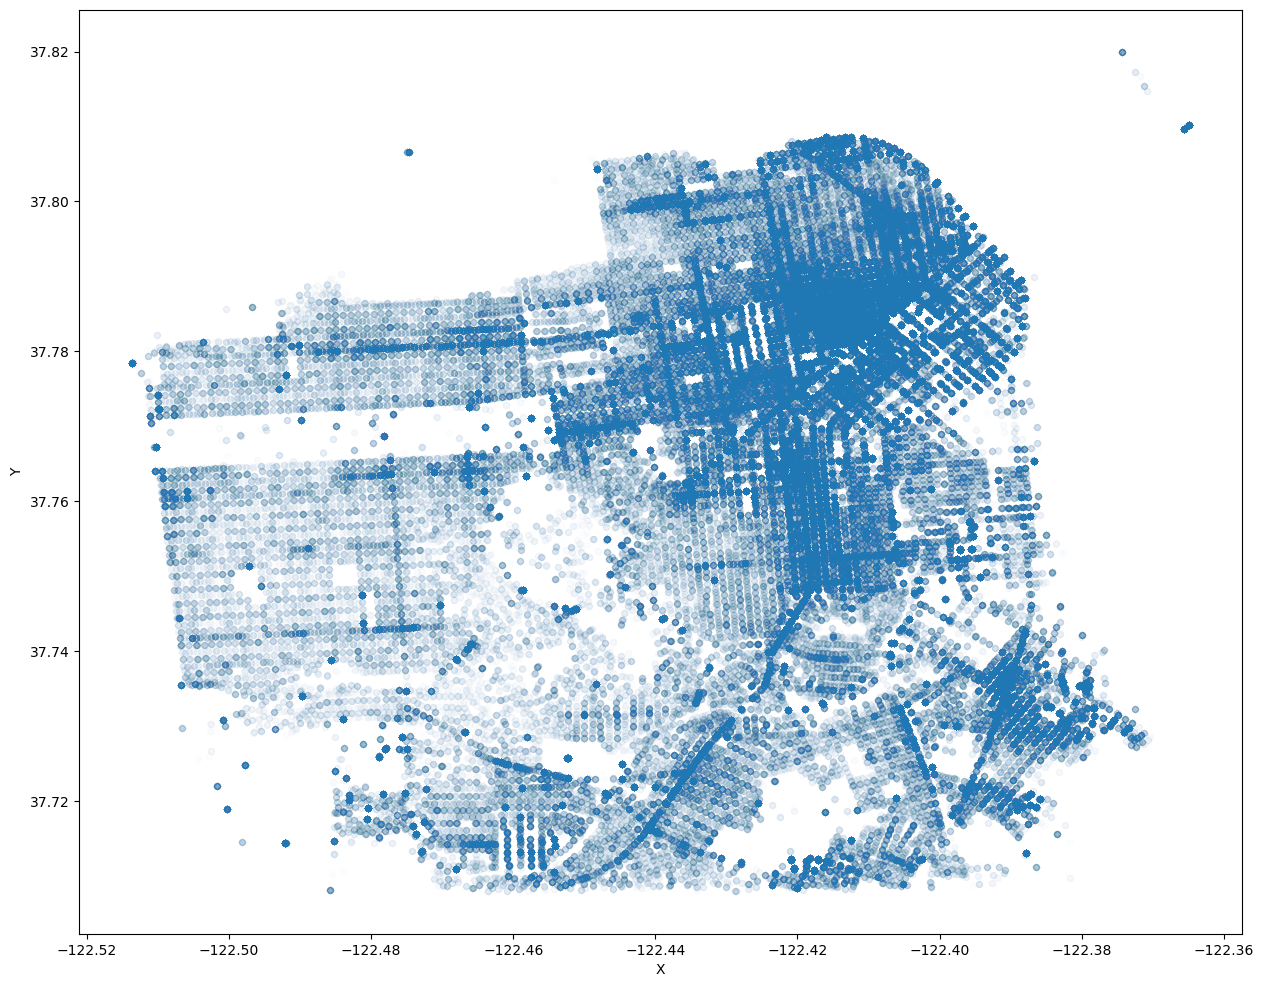

In [14]:
# plot to visualize the crimes
train_copy.plot(x="X", y="Y", kind="scatter", alpha=0.01,figsize=(15,12))

In [15]:
# Look at the different types of crime committed
train_copy["Category"].value_counts()

LARCENY/THEFT                  174885
OTHER OFFENSES                 126165
NON-CRIMINAL                    92300
ASSAULT                         76872
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53772
VANDALISM                       44724
WARRANTS                        42206
BURGLARY                        36754
SUSPICIOUS OCC                  31412
MISSING PERSON                  25989
ROBBERY                         22999
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7325
STOLEN PROPERTY                  4539
SEX OFFENSES FORCIBLE            4387
DISORDERLY CONDUCT               4318
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [16]:
print("Most common resolutions for each category in percentage\n")
for i in train_copy.groupby(['Category'])['Resolution']:
  print(i[0])
  print(round(i[1].value_counts()[:3]/i[1].count()*100,1))
  print()

Most common resolutions for each category in percentage

ARSON
NONE               82.5
ARREST, BOOKED     13.4
JUVENILE BOOKED     1.1
Name: Resolution, dtype: float64

ASSAULT
NONE              58.2
ARREST, BOOKED    30.5
ARREST, CITED      4.6
Name: Resolution, dtype: float64

BAD CHECKS
NONE                            79.1
ARREST, BOOKED                   6.2
PROSECUTED BY OUTSIDE AGENCY     6.2
Name: Resolution, dtype: float64

BRIBERY
ARREST, BOOKED     55.0
NONE               37.4
JUVENILE BOOKED     2.1
Name: Resolution, dtype: float64

BURGLARY
NONE              83.9
ARREST, BOOKED    13.2
UNFOUNDED          0.7
Name: Resolution, dtype: float64

DISORDERLY CONDUCT
ARREST, BOOKED    34.9
NONE              31.6
ARREST, CITED     31.0
Name: Resolution, dtype: float64

DRIVING UNDER THE INFLUENCE
ARREST, BOOKED    85.5
ARREST, CITED      8.2
NONE               5.7
Name: Resolution, dtype: float64

DRUG/NARCOTIC
ARREST, BOOKED    81.1
NONE               8.6
ARREST, CITED      8.3
Na

### Feature Engineering

In [17]:
# Feature engineering to find out if crime is committed in day versus night
# use rough timing for sunset/sunrise as night/day from https://meteogram.org/sun/united-states/san-francisco/
# Set roughly 7am to 7pm as Day, else is night
train_df['IsDay'] = 0
train_df.loc[ (train_df.Date.dt.hour > 7) & (train_df.Date.dt.hour < 19), 'IsDay' ] = 1
test_df['IsDay'] = 0
test_df.loc[ (test_df.Date.dt.hour > 7) & (test_df.Date.dt.hour < 19), 'IsDay' ] = 1


In [18]:
train_df.sample(3)

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Date,IsDay
24884,ASSAULT,"BATTERY, FORMER SPOUSE OR DATING RELATIONSHIP",Sunday,BAYVIEW,EXCEPTIONAL CLEARANCE,0 Block of ESPANOLA ST,-122.379974,37.731077,2015-01-11 13:22:00,1
200743,LARCENY/THEFT,GRAND THEFT OF PROPERTY,Monday,SOUTHERN,NONE,0 Block of THE EMBARCADEROSOUTH ST,-122.387915,37.783363,2012-09-17 07:00:00,0
827706,ASSAULT,BATTERY,Thursday,MISSION,"ARREST, CITED",3400 Block of 17TH ST,-122.422220,37.763326,2003-09-04 11:55:00,1


In [19]:
train_df.DayOfWeek.dtype

dtype('O')

In [20]:
# Change type to int for DayOfWeek
days_int = {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7,
}
train_df['DayOfWeek'] = train_df['DayOfWeek'].map(days_int)
test_df ['DayOfWeek'] = test_df ['DayOfWeek'].map(days_int)

In [21]:
train_df.DayOfWeek.unique()

array([3, 2, 1, 7, 6, 5, 4], dtype=int64)

In [22]:
# split up time into respective columns: year, day, hour
train_df['Hour'] = train_df.Date.dt.hour
train_df['Month'] = train_df.Date.dt.month
train_df['Year'] = train_df.Date.dt.year

test_df['Hour'] = test_df.Date.dt.hour
test_df['Month'] = test_df.Date.dt.month
test_df['Year'] = test_df.Date.dt.year

In [23]:
train_df.sample(1)

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Date,IsDay,Hour,Month,Year
613893,BURGLARY,"BURGLARY, HOT PROWL, UNLAWFUL ENTRY",6,NORTHERN,NONE,1400 Block of FILLMORE ST,-122.432681,37.782821,2006-08-26 01:30:00,0,1,8,2006


In [24]:
test_df.sample(1)

,Id,DayOfWeek,PdDistrict,Address,X,Y,Date,IsDay,Hour,Month,Year
224868,224868,7,NORTHERN,HAIGHT ST / STEINER ST,-122.432096,37.771896,2012-05-13 01:00:00,0,1,5,2012


In [25]:
# Dummy encoding of PdDistrict
train_df = pd.get_dummies(train_df, columns=['PdDistrict'])
test_df  = pd.get_dummies(test_df,  columns=['PdDistrict'])
train_df.sample(5)

,Category,Descript,DayOfWeek,Resolution,Address,X,Y,Date,IsDay,Hour,...,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
308048,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,6,NONE,800 Block of OFARRELL ST,-122.418751,37.785116,2011-02-12 21:00:00,0,21,...,0,0,0,0,1,0,0,0,0,0
810335,WARRANTS,WARRANT ARREST,3,"ARREST, BOOKED",300 Block of CASTRO ST,-122.435290,37.763050,2003-11-26 17:20:00,1,17,...,0,0,0,0,0,1,0,0,0,0
361005,SECONDARY CODES,DOMESTIC VIOLENCE,5,"ARREST, BOOKED",16TH ST / POTRERO AV,-122.407538,37.765783,2010-05-07 12:45:00,1,12,...,0,0,0,1,0,0,0,0,0,0
96912,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",7,PSYCHOPATHIC CASE,1100 Block of SHAFTER AV,-122.382371,37.726233,2014-01-26 02:20:00,0,2,...,1,0,0,0,0,0,0,0,0,0
552853,RECOVERED VEHICLE,RECOVERED VEHICLE - STOLEN OUTSIDE SF,3,NONE,300 Block of BAKER ST,-122.440950,37.774119,2007-07-25 19:30:00,0,19,...,0,0,0,0,0,1,0,0,0,0


In [26]:
# label encoding for category
category_label_encoder = LabelEncoder()
train_df['CategoryInt'] = pd.Series(category_label_encoder.fit_transform(train_df.Category))
train_df.sample(5)

,Category,Descript,DayOfWeek,Resolution,Address,X,Y,Date,IsDay,Hour,...,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,CategoryInt
24812,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",7,NONE,LOMBARD ST / BRODERICK ST,-122.444320,37.798788,2015-01-11 16:34:00,1,16,...,0,0,0,1,0,0,0,0,0,20
643376,PROSTITUTION,ENGAGING IN LEWD CONDUCT - PROSTITUTION RELATED,7,"ARREST, CITED",CAROLINA ST / 17TH ST,-122.400637,37.764897,2006-03-26 08:10:00,1,8,...,0,0,0,0,0,0,0,0,0,23
782749,SEX OFFENSES FORCIBLE,SEXUAL BATTERY,2,NONE,500 Block of CALIFORNIA ST,-122.403305,37.792728,2004-04-13 21:12:00,0,21,...,1,0,0,0,0,0,0,0,0,28
850387,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,4,NONE,1000 Block of POTRERO AV,-122.406539,37.756486,2003-05-15 00:01:00,0,0,...,0,0,1,0,0,0,0,0,0,16
561798,LARCENY/THEFT,GRAND THEFT FROM PERSON,1,NONE,MISSION ST / 18TH ST,-122.419360,37.761836,2007-06-11 11:15:00,1,11,...,0,0,1,0,0,0,0,0,0,16


In [27]:
# In address, if it contains "/", mark as an 'intersection'
train_df['InIntersection'] = 1
train_df.loc[train_df.Address.str.contains('Block'), 'InIntersection'] = 0

test_df['InIntersection'] = 1
test_df.loc[test_df.Address.str.contains('Block'), 'InIntersection'] = 0

In [28]:
train_df.sample()

,Category,Descript,DayOfWeek,Resolution,Address,X,Y,Date,IsDay,Hour,...,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,CategoryInt,InIntersection
788432,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,3,NONE,PRECITA AV / FOLSOM ST,-122.413575,37.747171,2004-03-17 12:51:00,1,12,...,1,0,0,0,0,0,0,0,32,1


In [29]:
train_df.columns

Index(['Category', 'Descript', 'DayOfWeek', 'Resolution', 'Address', 'X', 'Y',
       'Date', 'IsDay', 'Hour', 'Month', 'Year', 'PdDistrict_BAYVIEW',
       'PdDistrict_CENTRAL', 'PdDistrict_INGLESIDE', 'PdDistrict_MISSION',
       'PdDistrict_NORTHERN', 'PdDistrict_PARK', 'PdDistrict_RICHMOND',
       'PdDistrict_SOUTHERN', 'PdDistrict_TARAVAL', 'PdDistrict_TENDERLOIN',
       'CategoryInt', 'InIntersection'],
      dtype='object')

In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Category               878049 non-null  object        
 1   Descript               878049 non-null  object        
 2   DayOfWeek              878049 non-null  int64         
 3   Resolution             878049 non-null  object        
 4   Address                878049 non-null  object        
 5   X                      878049 non-null  float64       
 6   Y                      878049 non-null  float64       
 7   Date                   878049 non-null  datetime64[ns]
 8   IsDay                  878049 non-null  int64         
 9   Hour                   878049 non-null  int64         
 10  Month                  878049 non-null  int64         
 11  Year                   878049 non-null  int64         
 12  PdDistrict_BAYVIEW     878049 non-null  uint

In [31]:
# Select only numeric columns to prep for training
# Split the data into input features (X) and target variable (y)
X = train_df.drop(['Category','Descript','Address','Resolution','Date','CategoryInt','InIntersection'], axis=1)
y = train_df['CategoryInt']

In [32]:
test_id = test_df['Id']
test_x = test_df.drop(['Id','Address','Date', 'InIntersection'], axis=1)

In [33]:
X.sample(1)

,DayOfWeek,X,Y,IsDay,Hour,Month,Year,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
598964,3,-122.478035,37.776595,1,16,11,2006,0,0,0,0,0,0,1,0,0,0


In [34]:
test_x.sample(1)

,DayOfWeek,X,Y,IsDay,Hour,Month,Year,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
534577,5,-122.416583,37.778659,0,3,11,2007,0,0,0,0,0,0,0,0,0,1


In [35]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   DayOfWeek              878049 non-null  int64  
 1   X                      878049 non-null  float64
 2   Y                      878049 non-null  float64
 3   IsDay                  878049 non-null  int64  
 4   Hour                   878049 non-null  int64  
 5   Month                  878049 non-null  int64  
 6   Year                   878049 non-null  int64  
 7   PdDistrict_BAYVIEW     878049 non-null  uint8  
 8   PdDistrict_CENTRAL     878049 non-null  uint8  
 9   PdDistrict_INGLESIDE   878049 non-null  uint8  
 10  PdDistrict_MISSION     878049 non-null  uint8  
 11  PdDistrict_NORTHERN    878049 non-null  uint8  
 12  PdDistrict_PARK        878049 non-null  uint8  
 13  PdDistrict_RICHMOND    878049 non-null  uint8  
 14  PdDistrict_SOUTHERN    878049 non-nu

In [36]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   DayOfWeek              884262 non-null  int64  
 1   X                      884262 non-null  float64
 2   Y                      884262 non-null  float64
 3   IsDay                  884262 non-null  int64  
 4   Hour                   884262 non-null  int64  
 5   Month                  884262 non-null  int64  
 6   Year                   884262 non-null  int64  
 7   PdDistrict_BAYVIEW     884262 non-null  uint8  
 8   PdDistrict_CENTRAL     884262 non-null  uint8  
 9   PdDistrict_INGLESIDE   884262 non-null  uint8  
 10  PdDistrict_MISSION     884262 non-null  uint8  
 11  PdDistrict_NORTHERN    884262 non-null  uint8  
 12  PdDistrict_PARK        884262 non-null  uint8  
 13  PdDistrict_RICHMOND    884262 non-null  uint8  
 14  PdDistrict_SOUTHERN    884262 non-nu

### XGBoost Training

In [37]:
train_xgb = xgb.DMatrix(X, label=y)
test_xgb  = xgb.DMatrix(test_x)

In [47]:
# XGBoost parameters
params = {
    'max_depth': 5,
    'eta': 0.4, 
    'objective': 'multi:softprob',
    'num_class': 39,
}

In [48]:
CROSS_VAL = False
if CROSS_VAL:
    print('Doing Cross-validation ...')
    cv = xgb.cv(params, train_xgb, nfold=3, early_stopping_rounds=10, metrics='mlogloss', verbose_eval=True)
    cv

In [49]:
# Make predictions on the testing data
result = xgb_model.predict(test_xgb)

In [50]:
SUBMIT = not CROSS_VAL
if SUBMIT:
    print('Fitting Model ...')
    
    # Train XGBoost Model
    num_rounds = 20
    xgb_model = xgb.train(params, train_xgb, num_rounds)
    # Make predictions on the testing data
    result = xgb_model.predict(test_xgb)
    
    cols = ['Id'] + category_label_encoder.classes_
    submission = pd.DataFrame(result, columns=category_label_encoder.classes_)
    submission.insert(0, 'Id', test_id)
    submission.to_csv('submission.csv', index=False)
    print('Done Outputing !')
    print(submission.sample(3))
else:
    print('NOT SUBMITING')

Fitting Model ...
Done Outputing !
            Id     ARSON   ASSAULT  BAD CHECKS   BRIBERY  BURGLARY  \
143517  143517  0.001730  0.106968    0.000440  0.000757  0.028355   
340760  340760  0.000569  0.050671    0.000517  0.000341  0.029260   
492304  492304  0.002089  0.134163    0.001640  0.001339  0.028865   

        DISORDERLY CONDUCT  DRIVING UNDER THE INFLUENCE  DRUG/NARCOTIC  \
143517            0.004275                     0.006449       0.027575   
340760            0.002242                     0.000939       0.019902   
492304            0.005578                     0.003277       0.053630   

        DRUNKENNESS  ...  SEX OFFENSES NON FORCIBLE  STOLEN PROPERTY  \
143517     0.007474  ...                   0.000463         0.009669   
340760     0.003307  ...                   0.000293         0.003880   
492304     0.009327  ...                   0.000722         0.004852   

         SUICIDE  SUSPICIOUS OCC      TREA  TRESPASS  VANDALISM  \
143517  0.000552        0.02866